In [15]:
import numpy as np
from tqdm import tqdm

from scipy.optimize import minimize_scalar
from scipy.interpolate import interp1d
from scipy.interpolate import RegularGridInterpolator



import matplotlib
from matplotlib import ticker
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"font.size" : 15,
                     "figure.dpi" : 100, 
                     "grid.alpha" : 0.3, 
                     "axes.grid": True, 
                     "axes.axisbelow" : True,
                     "figure.figsize":(8,6),
                     "mathtext.fontset":"cm",
                     "xtick.labelsize": 14,
                     "ytick.labelsize": 14,
                     "axes.labelsize": 16, 
                     "legend.fontsize": 13.5})

USE_TEX = False
if USE_TEX:
    plt.rc("text", usetex=True)
    plt.rc("text.latex", preamble=r"""
     \usepackage{times}
     \usepackage{mathptmx}""")
else:
    plt.rc("text", usetex=False)
plt.rc("font", family="serif")

# Optimal Growth Model

In [2]:
def maximize(g, a, b, args):
    """
    Maximize the function g over the interval [a, b].
    Returns the maximal value and the maximizer.
    """
    objective = lambda x: -g(x, *args)
    result = minimize_scalar(objective, bounds=(a, b), method='bounded')
    maximizer, maximum = result.x, -result.fun
    return maximizer, maximum

In [51]:
def f(i, r, p):
    """
    Return production given investment amount, expected returns, and portfolio.
    """
    return sum(i*r*p)


def u(x, rho=1.4):
    """
    CRRA utility function.
    """ 
    if rho==1:
        return np.log(x)
    else:
        return (x**(1-RHO))/(1-RHO)

In [49]:
class OptimalGrowthModel:

    def __init__(self,
                 u,            # utility function
                 f,            # production function
                 β=0.89,       # discount factor
                 grid_max=5000,
                 grid_size=250):

        # initialize
        self.u = u
        self.f = f
        self.β = β

        # Set up grid
        self.grid = np.linspace(1e-4, grid_max, grid_size)


    def state_action_value(self, c, y, v_array, alpha=0.4):
        """
        Right hand side of the Bellman equation.
        """        
        u, f, β = self.u, self.f, self.β
        v = interp1d(self.grid, v_array, fill_value="extrapolate")
        
        out = u(c) + β * v( ((y*RR)-c)**alpha )

        
        return out


def T(v, og):
    """
    The Bellman operator.  Updates the guess of the value function
    and also computes a v-greedy policy.
      * og is an instance of OptimalGrowthModel
      * v is an array representing a guess of the value function
    """
    v_new = np.empty_like(v)
    v_greedy = np.empty_like(v)

    for i in range(len(grid)):
        y = grid[i]

        # Maximize RHS of Bellman equation at state y
        c_star, v_max = maximize(og.state_action_value, 1e-10, y, (y, v))
        v_new[i] = v_max
        v_greedy[i] = c_star

    return v_greedy, v_new

In [47]:
og = OptimalGrowthModel(u=u, f=f)
grid = og.grid

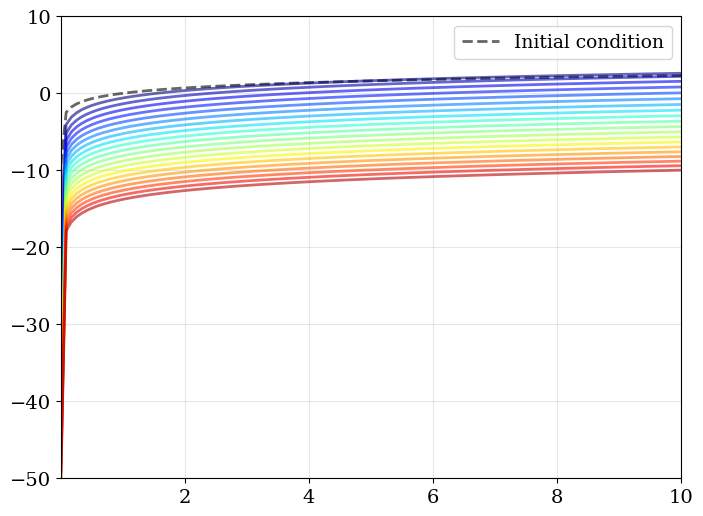

In [48]:
v = u(grid)
n = 20

fig, ax = plt.subplots()
ax.plot(grid, v, color='k', linestyle="dashed", lw=2, alpha=0.6, label='Initial condition')

for i in range(n):
    v_greedy, v = T(v, og)  # Apply the Bellman operator
    ax.plot(grid, v, color=plt.cm.jet(i / n), lw=2, alpha=0.6)

ax.legend()
ax.set(ylim=(-50, 10), xlim=(np.min(grid), np.max(grid)))
plt.show()

In [44]:
def solve_model(og, tol=1e-4, max_iter=1000, verbose=True, print_skip=25):
    """
    Solve model by iterating with the Bellman operator.
    """
    # Set up loop
    v = og.u(og.grid)  # Initial condition
    i = 0
    delta = tol + 1

    while i < max_iter and delta > tol:
        v_greedy, v_new = T(v, og)
        delta = np.max(np.abs(v - v_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Delta at iteration {i} is {delta}.")
        v = v_new

    if delta > tol:
        print("Failed to converge!")
    elif verbose:
        print(f"Converged in {i} iterations.\n")

    return v_greedy, v_new

Delta at iteration 25 is 1.7339823203224114.
Delta at iteration 50 is 0.09414447354726008.
Delta at iteration 75 is 0.005111460447551508.
Delta at iteration 100 is 0.00027752056027452454.
Converged in 109 iterations.

Delta at iteration 25 is 11.205762737606847.
Delta at iteration 50 is 0.6084033389965953.
Delta at iteration 75 is 0.03303252368004905.
Delta at iteration 100 is 0.0017934609345502395.
Delta at iteration 125 is 9.737379332364071e-05.
Converged in 125 iterations.

Delta at iteration 25 is 112.96824962498067.
Delta at iteration 50 is 6.133474525000565.
Delta at iteration 75 is 0.3330095834353415.
Delta at iteration 100 is 0.018080352698234492.
Delta at iteration 125 is 0.0009816508936637547.
Converged in 145 iterations.

Delta at iteration 25 is 1.733209141081403.
Delta at iteration 50 is 0.09410249471525844.
Delta at iteration 75 is 0.0051091811734806925.
Delta at iteration 100 is 0.0002773968152496309.
Converged in 109 iterations.

Delta at iteration 25 is 11.200129205885

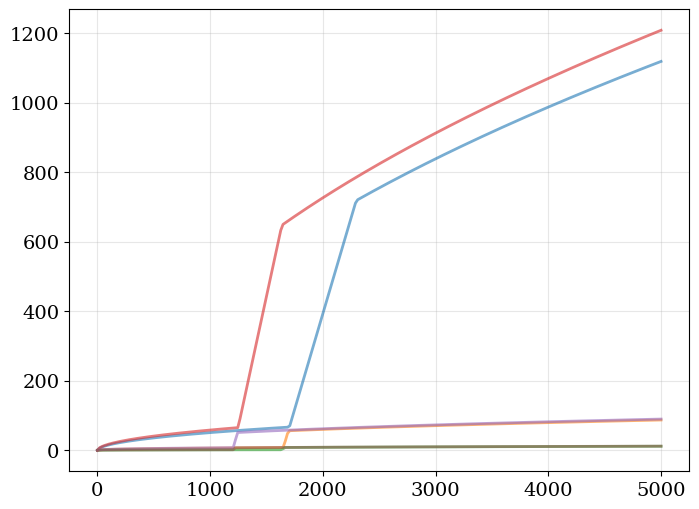

In [53]:
results = []

return_vals = [1.1, 1.5]
rhos = [1.2, 1.5, 1.8]

for RR in return_vals:
    for RHO in rhos:
        og = OptimalGrowthModel(u=u, f=f)
        grid = og.grid
        v_greedy, v_solution = solve_model(og)
        results.append(v_greedy)
        plt.plot(grid, v_greedy, lw=2, alpha=0.6, label=f'{RR}, {RHO}')

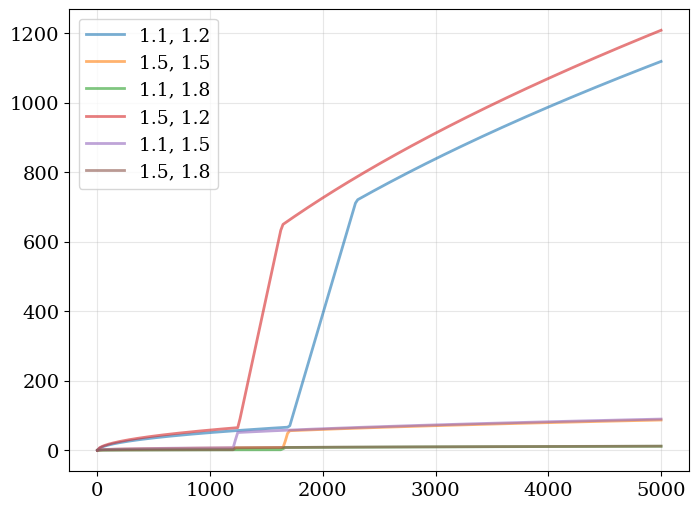

In [56]:
for i,r in enumerate(results):
    plt.plot(grid, r, lw=2, alpha=0.6, label=f'{return_vals[i%2]}, {rhos[i%3]}')
    
plt.legend()

Delta at iteration 25 is 5.540720426424855.
Delta at iteration 50 is 0.30082671634227154.
Delta at iteration 75 is 0.01633302283858029.
Delta at iteration 100 is 0.0008867817271038803.
Converged in 119 iterations.

Delta at iteration 25 is 5.5402482187138276.
Delta at iteration 50 is 0.30080107839569337.
Delta at iteration 75 is 0.0163316308571666.
Delta at iteration 100 is 0.0008867061511637075.
Converged in 119 iterations.

Delta at iteration 25 is 5.5398358994749515.
Delta at iteration 50 is 0.30077869202114016.
Delta at iteration 75 is 0.016330415415950483.
Delta at iteration 100 is 0.0008866401603881968.
Converged in 119 iterations.

Delta at iteration 25 is 5.539465303980137.
Delta at iteration 50 is 0.300758570987.
Delta at iteration 75 is 0.01632932296877243.
Delta at iteration 100 is 0.0008865808472364733.
Converged in 119 iterations.

Delta at iteration 25 is 5.539125772632815.
Delta at iteration 50 is 0.3007401365427995.
Delta at iteration 75 is 0.016328322092931558.
Delta a

KeyboardInterrupt: 

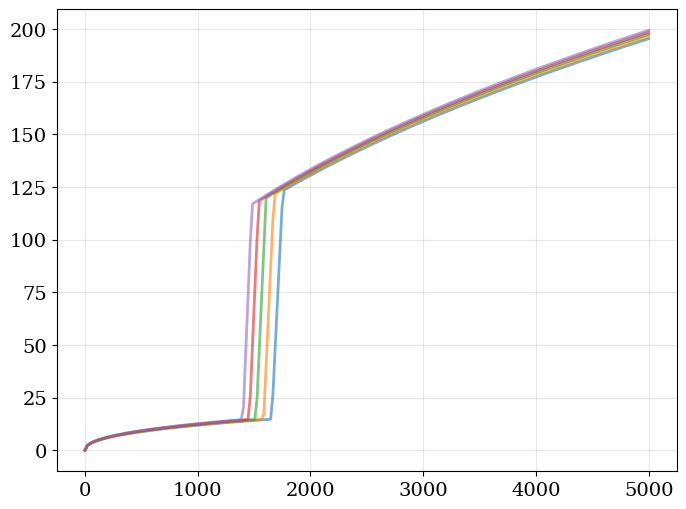

In [50]:
# beta = 0.8
results = []

return_vals = np.linspace(1.1, 1.7, 13)

for RR in return_vals:
    og = OptimalGrowthModel(u=u, f=f)
    grid = og.grid
    v_greedy, v_solution = solve_model(og)
    results.append(v_greedy)
    plt.plot(grid, v_greedy, lw=2, alpha=0.6, label=f'{RR}')

    
plt.xlabel("Wealth")
plt.ylabel("Optimal Consumption")
plt.legend()
plt.show()

In [7]:
with open("growth.pickle", "rb") as f:
    results = pickle.load(f)

In [9]:
grid = np.linspace(1e-4, 5000, 200)

In [11]:
return_vals = np.array([1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7])

In [31]:
x = grid
y = return_vals

xg, yg = np.meshgrid(x, y, indexing='ij')

stacked = np.row_stack(results).T

interp = RegularGridInterpolator((x, y), stacked, bounds_error=False, fill_value=None, method="linear")

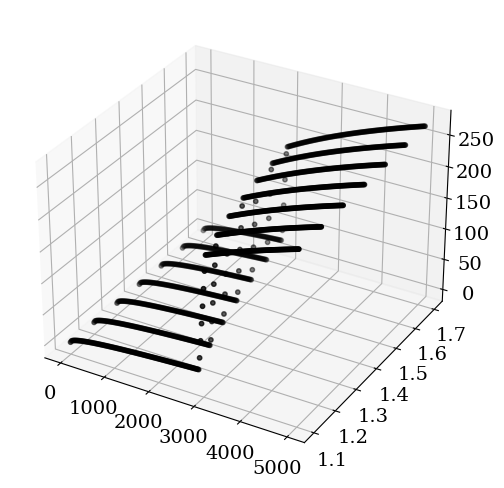

In [32]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(xg.ravel(), yg.ravel(), stacked.ravel(), s=10, c='k')
plt.show()

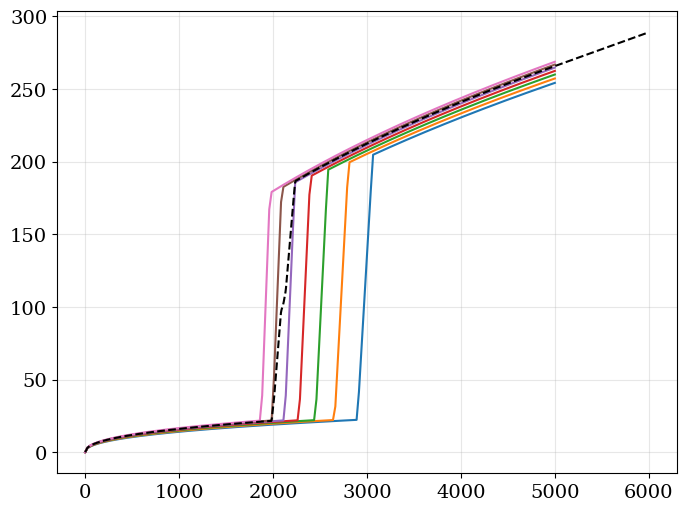

In [38]:
xtest = grid
ytest = 1.55

linspace = np.linspace(0, 6000, 1000)
interpolatedd = interp((linspace, ytest))


for r in results:
    plt.plot(grid, r)
plt.plot(linspace, interpolatedd, color="k", linestyle="dashed")
plt.show()

In [140]:
from network_model import *

In [187]:
G = generate_gambles(100, left=1.6, right=2)

In [188]:
expected = []
for g in G:
    o = g["outcomes"]
    p = g["probs"]
    expected.append(o[0]*p[0]+o[1]*p[1])

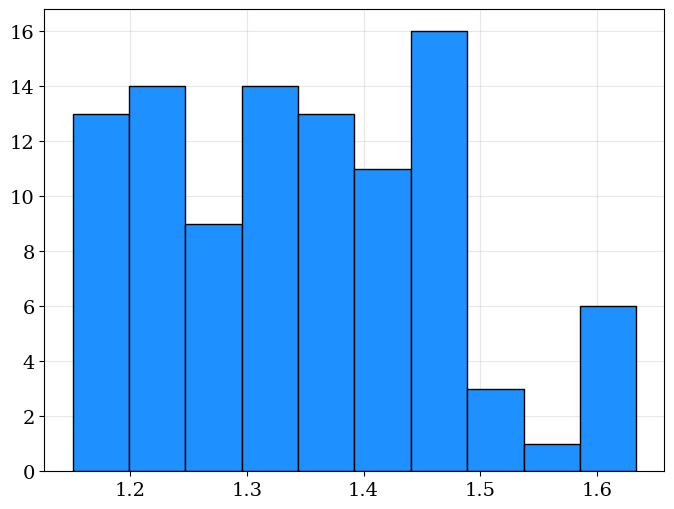

In [189]:
plt.hist(expected, color="dodgerblue", edgecolor="k")
plt.show()

In [190]:
min(expected), max(expected)

(1.1508454161071224, 1.633532430180653)

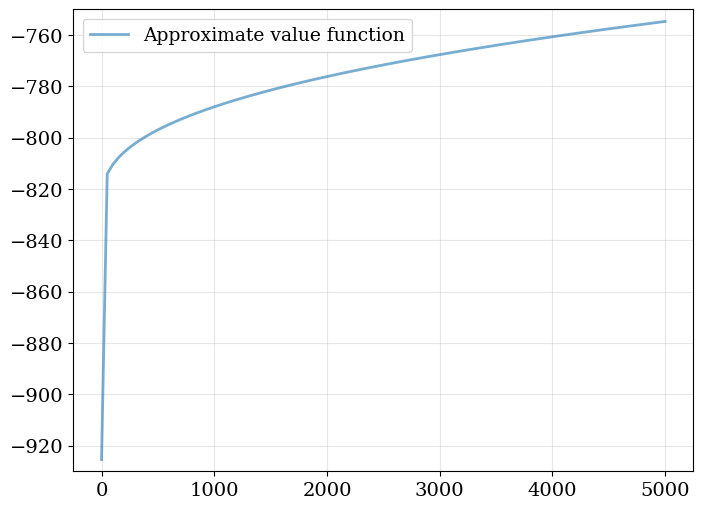

In [139]:
fig, ax = plt.subplots()
ax.plot(grid, v_solution, lw=2, alpha=0.6, label='Approximate value function')
ax.legend()
ax.set_ylim(-930, -750)
plt.show()